In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import LeakyReLU
from keras.utils import plot_model
from keras import optimizers
from keras import backend
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pull only specific columns out

# 'Timestamp', 'MMSI', 'Latitude', 'Longitude', 'SOG', 'COG'
fields = [1, 0, 2, 3, 4, 5]
n_rows = 50000            # Pulls this many rows of data, because all of it is too much
df = pd.read_csv('/content/drive/MyDrive/data/data.csv', skipinitialspace=True, usecols=fields, nrows=n_rows)

# get rid of nan rows (in speed and course) - could just set to -1
df = df.dropna()

# sort by MMSI, then by time/date
df = df.sort_values(by=['MMSI', 'BaseDateTime'], ascending=True)

# Filter data so that only groups who have 4 or more Rows are shown
# Extract the first 4 rows per group
df = df.groupby(['MMSI']).filter(lambda x: len(x) >= 4)

# change dataframe to numpy array
df = df.values


# new number of rows and columns
n_rows, n_cols = df.shape

<ipython-input-3-62f9d8504c30>:5: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/data/data.csv', skipinitialspace=True, usecols=fields, nrows=n_rows)


In [ ]:
#Converts timestamp to integer for each row
for i in range(n_rows):
    df[i][1] = int(df[i][1][11:13])*3600 + int(df[i][1][14:16])*60 + int(df[i][1][17:])


In [ ]:
# create timedeltas
i = 0
while i in range(n_rows):
    end = False
    temp = []
    start = i
    try:
        while df[i+1][0] == df[i][0]:
            temp.append(df[i][1])
            i += 1
            end = True
    except: pass

    if end is True:
        temp.append(df[i][1])
        diff_array = np.diff(temp)

        df[start][1] = 0
        df[start+1:i+1, 1] = diff_array
    i += 1

In [ ]:
#np.savez('/content/drive/MyDrive/data/SortedData.npz', sorted_data=df)

In [ ]:
MMSI_Values = df[:, 0]
unique_MMSI, count_unique = np.unique(MMSI_Values, return_counts=True)

In [ ]:
i = 0

for count, k in enumerate(MMSI_Values):
    try:
        if MMSI_Values[count + 3] == k:
            i+=1
    except:
        pass
SizeOfTrain = i

In [ ]:
x_train = np.empty([SizeOfTrain, 3, 6])
y_train = np.empty([SizeOfTrain, 6])

In [ ]:
i = 0
for count, k in enumerate(MMSI_Values):
  try:
    if MMSI_Values[count + 3] == k:
      y_train[i][:] = df[count + 0][:]
      x_train[i][0][:] = df[count + 1][:]
      x_train[i][1][:] = df[count + 2][:]
      x_train[i][2][:] = df[count + 3][:]
      i += 1
  except:
    pass

In [ ]:
#Remove MMSI for train data and everything but lat and long for target data
x_train = x_train[0:i-1, :, [1,2,3,4,5]] #Remove MMSI
y_train = y_train[0:i-1, [2,3]] #Keep longitude and latitude

In [ ]:
# splice data for training and testing
train_length = int(i * 0.8)
y_test = y_train[train_length:, :]
x_test = x_train[train_length:, :, :]

y_train = y_train[:train_length + 1, :]
x_train = x_train[:train_length + 1, :, :]

In [ ]:
NUM_EPOCHS = 50                 # Number of Epochs to Train Over
BATCH_SIZE = 10                 # Number of batches

num_features = 5       # The data we are submitting per time step (lat, long, speed, time, course)
num_timesteps = 3       # The number of time steps per sequence (track)

In [ ]:
# Defining Layers
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(num_timesteps, num_features)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(2))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4864      
                                                                 
 lstm_1 (LSTM)               (None, 3, 16)             3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 8818 (34.45 KB)
Trainable params: 8818 (34.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Fit the Model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.20)

In [ ]:
#Evaluate the Model
scores = model.evaluate(x_train, y_train)
print('\n%s: %f\n' % ("mse", scores))

511/511 [==============================] - 3s 5ms/step - loss: 2.5005

mse: 2.500487



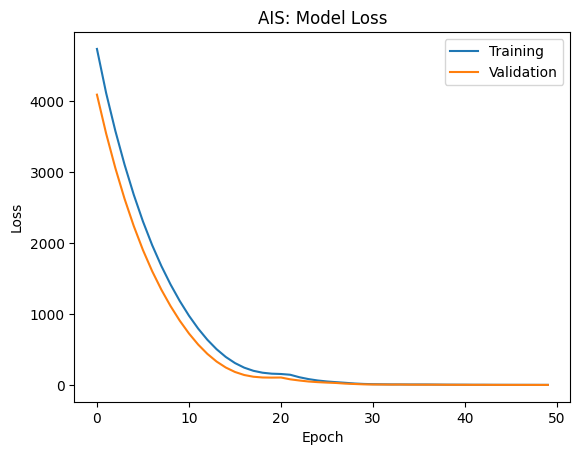

In [ ]:
# summarize history for loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('AIS: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
prediction = model.predict(x_test)

128/128 [==============================] - 2s 3ms/step


In [ ]:
#y_test

In [ ]:
#prediction

In [ ]:
from math import sin, cos, sqrt, atan2

import math

def Distance(prediction, target):

    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    lat1 = prediction[0]
    lon1 = prediction[1]
    lat2 = target[0]
    lon2 = target[1]

    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    r = 6371.0 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [ ]:
DistanceErrors = []

for x in range(len(prediction)):
  DistanceErrors.append(Distance(prediction[x], y_test[x]))

In [ ]:
DistanceErrors

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
Average(DistanceErrors)

98.78943053581837